# Classification of MNIST

MNIST is a dataset consisting of handwritten numbers 0-9 widely used as a benchmark in machine learning. While the dataset is very simple, it is still in seminal papers to demonstrate proof of concept (i.e. [Dynamic Routing](https://arxiv.org/pdf/1710.09829.pdf)). Below we load some sample digits for you.

Benchmark datasets are very useful, to note a couple other widely used benchmarks: [SVHN](http://ufldl.stanford.edu/housenumbers/) (Street View House Numbers), [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) (Like MNIST, but more fashion), [CIFAR](https://www.cs.toronto.edu/~kriz/cifar.html) (10 and 100 different objects), and [ImageNet](http://www.image-net.org/) (very large real world image dataset).

We load up a downsampled MNIST dataset below. MNIST is usually 28x28, we will work with 8x8 images.

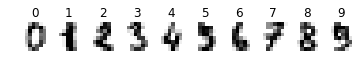

In [1]:
# Import datasets

%matplotlib inline

from sklearn import datasets
import matplotlib.pyplot as plt

digits = datasets.load_digits()
for index, (image, label) in enumerate(list(zip(digits.images, digits.target))[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title('%i' % label)
plt.show()

# Part I

You will classifiy two numbers of your choice. Start by extracting two features from the image. We suggest looking at intensity and symmetry using `sklearn.model_selection.train_test_split`, a convenient function which will save 10% of the data for testing. We split the dataset into training and test sets. Save your test set so we can evaluate how well you classify.

`X_test` and `y_test` should be used to evaluate the performance of the classifier you build. Moving forward just work with `X_train` and `y_train`.

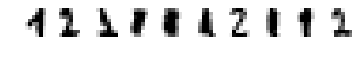

In [2]:
from sklearn.model_selection import train_test_split
import numpy as np
from numpy.linalg import norm

number_a = 1 # TODO choose your digit
number_b = 2 # TODO choose your digit

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)
for index, image in enumerate(X_train[:10]):
    plt.subplot(1, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r)
plt.show()

# Feature Extraction

You will create 2 feature extractors based on the numbers you choose. These will be two functions which take in an image and output a single float. For example, image intensity and symmetry can be used as a features.

In [3]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        feature1 = np.sum(np.sum(image[3:4,:]))  # Calculate total intensity of the middle two rows

        return feature1

    def compute_feature_b(image):
        feature2 = np.sum(np.sum(image[:,3:4]))  # Calculate total intensity of the middle two columns

        return feature2
    
    return compute_feature_a(image), compute_feature_b(image)

Once you compute these two features, you can apply them to your images. Don't worry about the details of the first function below, all it does is map the `compute_features` function you wrote to each image in your `X_train` variable.

Afterwards let us plot the features you've crafted to see if they can separate into two classes.

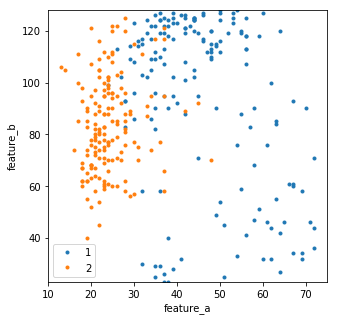

In [4]:
# Apply and plot your features

X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

X_features_test = np.apply_along_axis(compute_features, 1,
                                 X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.legend([str(number_a), str(number_b)])
plt.xlabel('feature_a')
plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 
plt.show()

# Linear Classification with Pseudo Inverse

`X_features` is a 2 dimensional array of features and `y_train` is our ground truth label. Find the best plane that separates these two classes using the pseudo inverse and plot it. For this problem, we need to set `y=-1` for `number_a` and `y=1` for `number_b`.

The loss $L$ we would like to minimize for each $i$ row in our matrix is.

$$L  = \frac{1}{2}\Sigma (y^{(i)} - W^{T}x^{(i)})^{2}$$

where

$$x^{(i)} = 
\begin{bmatrix}
    feature_a \\
    feature_b \\
\end{bmatrix}$$

$$W = 
\begin{bmatrix}
    w_1 \\
    w_2 \\
\end{bmatrix}$$


In matrix form we convert $x^{(i)}$ into $X$ which is the number of examples we have, in our case is MNIST digit features extracted.

$$X = 
\begin{bmatrix}
    feature_{a1} & feature_{b1} \\
    feature_{a2} & feature_{b2} \\
    ... & ... \\
    feature_{ai} & feature_{bi} \\
\end{bmatrix}$$


$$L  = \frac{1}{2}( Y-XW )^{T} (Y-XW)$$


### Explain

Let's solve L analytically, set $\frac{d}{dW}L = 0$ and solve. Show your steps.

Step 1: $$L  = \frac{1}{2}( Y-XW )^{T} (Y-XW)$$

Step 2: $$ \frac{d}{dW}L  = \frac{d}{dW} \frac{1}{2}( Y-XW )^{T} (Y-XW)$$

Step 3: We have: $$ \frac{d}{dW}L = 0 $$

Step 4: So: $$ Y-XW = 0 $$ or $$ Y = XW $$

Step 5: With that, we have: $$ W = X^{-1}Y $$

### Compute
Going back to linear algebra, we can re-write the classification problem as $Xw = y^*$, as we did during class. Here, $X$ is our features matrix `X_features` that has the features of each data example along each row, $y^*$ is our `pseudo_y` vector, and $w$ is the unknown weights vector that we'd like to figure out.

The pseudo inverse is $$(X^{T}X)^{-1}X^{T} = X^{+}$$

Solving for $w$, $$w = X^{+}y^*$$

To perform this computation: 

#### (a) create a features vector $X$ and compute its pseudo inverse. (This is the var `X_features`)

#### (b) create a vector like $y^*$ to hold the labels. (Done below for you as `pseudo_y`)

#### (c) find $w$

In [5]:
from numpy.linalg import inv, pinv

pseudo_y = np.copy(y_train)
pseudo_y[y_train == number_a] = -1
pseudo_y[y_train == number_b] = 1

pseudo_y_test = np.copy(y_test)
pseudo_y_test[y_test == number_a] = -1
pseudo_y_test[y_test == number_b] = 1

# Calculate x below
pseudoinv_X = np.matmul(inv(np.matmul(X_features.T, X_features)), X_features.T)
# pseudoinv_X = pinv(X_features)

# Find w
w = np.matmul(pseudoinv_X, pseudo_y)

### (d) To examine the result of the least squares solution under this formulation, compute the train and test error using an appropriate threshold. Does your trained model generalize well to the test data? 

Create a function called `accuracy_metrics` which does this.

In [6]:
def accuracy_metrics(features, label, weights, t=0):
    # features should be your X_features
    # label should be the y^{i} label

    if weights.shape[0] == 3:  # This is for bias case
        features = np.c_[np.ones((features.shape[0], 1)), features]
    
    pred = np.matmul(features,weights)
    if t == 0:
        pred[pred<t] = -1
        pred[pred>t] = 1
    if t == 0.5:
        pred[pred<t] = 0
        pred[pred>t] = 1
    
    accu = pred-label
    accu = [x for x in accu if x == 0]
    accu = len(accu)/features.shape[0]*100
    
    return accu # Return the % accuracy

print('Training accuracy: ')
print(accuracy_metrics(X_features, pseudo_y, w))

print('Testing accuracy: ')
print(accuracy_metrics(X_features_test, pseudo_y_test, w))

Training accuracy: 
73.37461300309597
Testing accuracy: 
80.55555555555556


The testing accuracy is even higher than the training accuracy (due to smaller size of testing data), meaning that the model generalizes well.

### (e) Write a function that visualizes the decision boundary corresponding to your chosen threshold (you can either draw a line or shade the region above/below the threshold). 

The function `visualize_model` should take in features, labels, and your calculated weights. It should show a matplotlib figure.

In [7]:
def visualize_model(features_a, features_b, features, labels, weights, t=0):
    
    if weights.shape[0] == 2:
        bound_x = (t-weights[1]*features[:,1])/(weights[0]+0.000001)
    else: bound_x = (t-weights[2]*features[:,1] - weights[0])/(weights[1]+0.000001)
    bound = np.c_[bound_x, features[:, 1]]
    
    plt.figure()
    plt.plot(features_a[:, 0], features_a[:, 1], '.')
    plt.plot(features_b[:, 0], features_b[:, 1], '.')
    plt.legend([str(number_b), str(number_a)])
    plt.plot(bound[:, 0], bound[:, 1])
    plt.xlabel('feature_a')
    plt.ylabel('feature_b')
    plt.ylim(features[:, 1].min(), features[:, 1].max()) 
    plt.show()
    return None

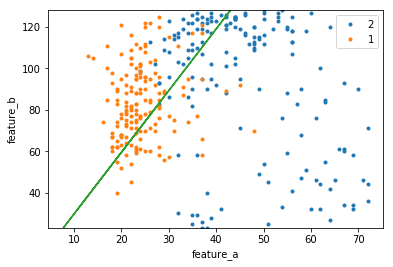

In [8]:
visualize_model(X_features_a, X_features_b, X_features, y_train, w)

### (f) Repeat the above steps after adding in a bias term, allowing for the classification line to not pass through the origin. You can do this by augmenting the X feature matrix with an additional feature column of ones, and making the unknown weight vector one entry longer -- does performance improve?

If you created your functions correctly, you shouldn't need to change them and you only need to modify `X_features`. 

Training accuracy: 
88.23529411764706
Testing accuracy: 
91.66666666666666


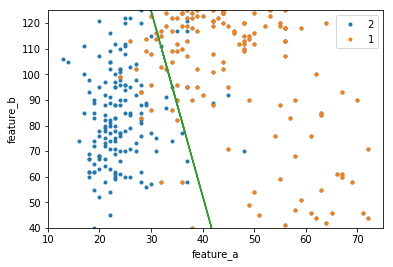

In [9]:
# Find w and bias
X_features_bias = np.c_[np.ones((X_features.shape[0], 1)), X_features]  # Concat a ones vector to X_features to account for bias
pseudoinv_X = np.matmul(inv(np.matmul(X_features_bias.T, X_features_bias)), X_features_bias.T)  # Recalculate pvin of X
w_b = np.matmul(pseudoinv_X, pseudo_y)

# Get the test and train accuracy of your model with bias
print('Training accuracy: ')
print(accuracy_metrics(X_features, pseudo_y, w_b))

print('Testing accuracy: ')
print(accuracy_metrics(X_features_test, pseudo_y_test, w_b))

# Visualize the model, you may need to change your code.
visualize_model(X_features, X_features_a, X_features_b, pseudo_y, w_b)

# Linear Classification with Finite Differences

Rather than use pseudo inverse (analytically solving your optimization equation). Instead, initialize your parameter x to some random numbers. Move x some small epsilon amount in the each direction to compute the total change in your loss and calculate the gradient. Then update x by taking a small step in that gradient direction. You can execute this in a for loop for a set number of iterations, or until the gradient reaches some threshold value of not changing very much.

1. Solve for x
2. Get training and test accuracy every $n$ steps
3. Plot the decision boundary every $n$ steps

### Define a loss.

In [10]:
def loss(features, labels, weights):
    
#     print(feature[1])
    if weights.shape[0] == 3:  # This is for bias case
        features = np.c_[np.ones((features.shape[0], 1)), features]
    
    mse = 0
    pred = np.matmul(features,weights)
#     pred[pred>0] = 1
#     pred[pred<0] = -1
    for i in range(features.shape[0]):
        pred = (np.matmul(weights.T, features[i,:]))
        pred = pred.astype(np.float64)
        mse += np.square(labels[i]-pred)
#     mse = np.mean(np.square(pred -label_t))
    return mse/features.shape[0]

### Now iteratively solve for your weights w

Training error without bias at  0 th step: 
49.22600619195047
Testing error without bias at  0 th step: 
50.0
Boundary without bias at  0 th step: 


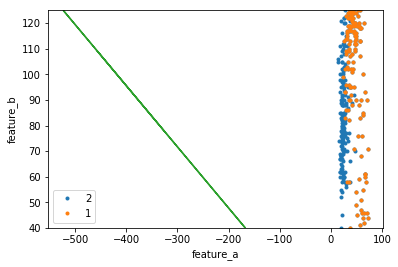

Training error without bias at  50 th step: 
49.22600619195047
Testing error without bias at  50 th step: 
50.0
Boundary without bias at  50 th step: 


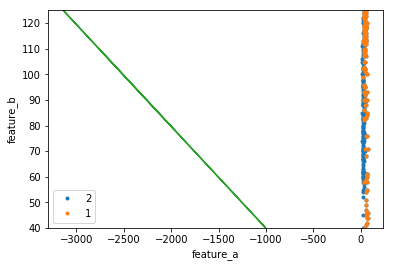

Training error without bias at  100 th step: 
49.22600619195047
Testing error without bias at  100 th step: 
50.0
Boundary without bias at  100 th step: 


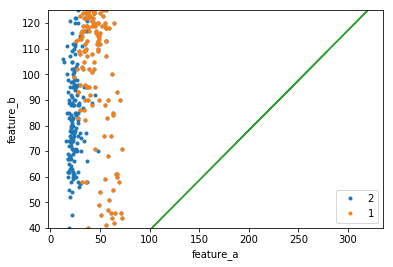

Training error without bias at  150 th step: 
60.99071207430341
Testing error without bias at  150 th step: 
69.44444444444444
Boundary without bias at  150 th step: 


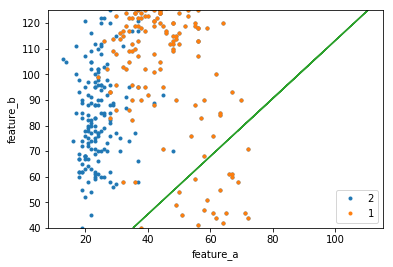

Training error without bias at  200 th step: 
65.63467492260062
Testing error without bias at  200 th step: 
69.44444444444444
Boundary without bias at  200 th step: 


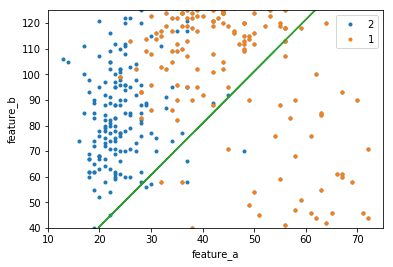

Training error without bias at  250 th step: 
71.20743034055728
Testing error without bias at  250 th step: 
80.55555555555556
Boundary without bias at  250 th step: 


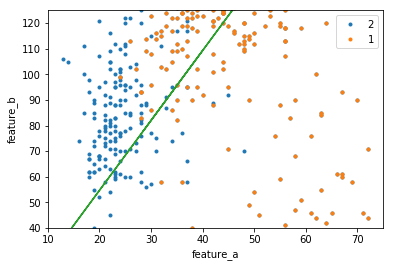

Training error without bias at  300 th step: 
73.9938080495356
Testing error without bias at  300 th step: 
80.55555555555556
Boundary without bias at  300 th step: 


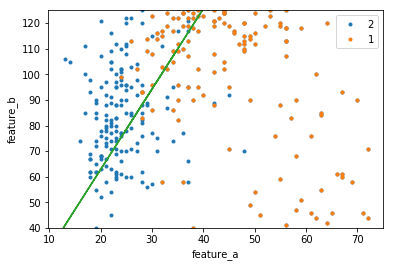

Training error without bias at  350 th step: 
73.06501547987617
Testing error without bias at  350 th step: 
72.22222222222221
Boundary without bias at  350 th step: 


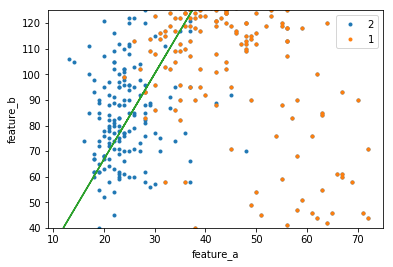

Training error without bias at  400 th step: 
70.27863777089783
Testing error without bias at  400 th step: 
75.0
Boundary without bias at  400 th step: 


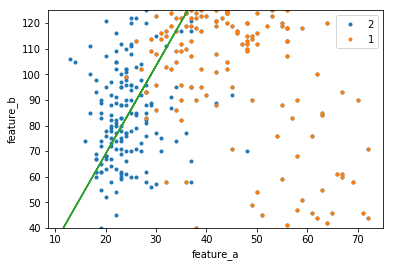

Training error without bias at  450 th step: 
69.3498452012384
Testing error without bias at  450 th step: 
80.55555555555556
Boundary without bias at  450 th step: 


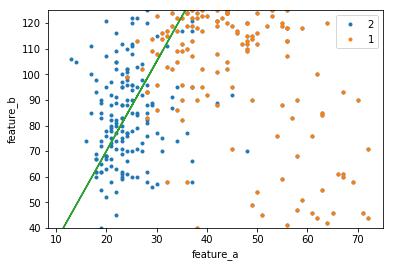

In [11]:
# Without bias
num_iterations = 500 # set this to the number of iterations
delta = 1e-2 # This may need to be adjusted
interval = num_iterations/10
step_size = 1e-6

w = np.random.rand(2) # init weights to some random value.
grad = np.ones((2,))
for i in range(num_iterations):
    w1 = np.copy(w)
    w1[0] = w1[0]+delta
    w2 = np.copy(w)
    w2[1] = w2[1]+delta
    grad[0] = (loss(X_features, pseudo_y, w1)-loss(X_features, pseudo_y, w))/delta
    grad[1] = (loss(X_features, pseudo_y, w2)-loss(X_features, pseudo_y, w))/delta
#     grad = grad/norm(grad)
    w -= step_size * (grad)
    if i % interval == 0:
        print('Training error without bias at ', str(i), 'th step: ')
        print(accuracy_metrics(X_features, pseudo_y, w))

        print('Testing error without bias at ', str(i), 'th step: ')
        print(accuracy_metrics(X_features_test, pseudo_y_test, w))
        
        print('Boundary without bias at ', str(i), 'th step: ')
        visualize_model(X_features, X_features_a, X_features_b, pseudo_y, w)

# Logistic Classification with Finite Differences

Now, let's consider the same problem with a different loss function.

$$L = \frac{1}{N}\sum_{i=1}^n ln(1 + e^{-y^{(i)}W^{T}x^{(i)}})$$

Use finite differences to compute the gradient and iteratively calculate $W$

1. Solve for x
2. Get training and test accuracy every $n$ steps
3. Plot the decision boundary every $n$ steps


In [12]:
logistic_y = np.copy(y_train)
logistic_y[y_train == number_a] = 0
logistic_y[y_train == number_b] = 1

logistic_y_test = np.copy(y_test)
logistic_y_test[y_test == number_a] = 0
logistic_y_test[y_test == number_b] = 1

In [13]:
def logistic_loss(features, labels, weights):
    
    if weights.shape[0] == 3:  # This is for bias case
        features = np.c_[np.ones((features.shape[0], 1)), features]
    log_loss = 0
    for i in range(features.shape[0]):
        pred = (np.matmul(features[i,:], weights))
        pred = pred.astype(np.float64)
        cur_loss = np.log(1+np.exp(np.float64(-labels[i]*pred)))
        log_loss += cur_loss

    return log_loss/features.shape[0]

Training accuracy without bias at  0 th step: 
10.8359133126935
Testing accuracy without bias at  0 th step: 
16.666666666666664
Boundary without bias at  0 th step: 


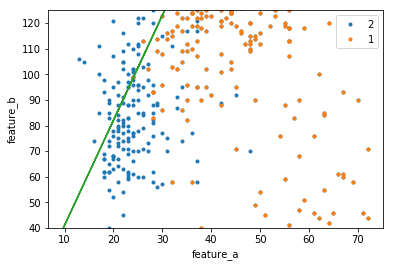

Training accuracy without bias at  1 th step: 
48.91640866873065
Testing accuracy without bias at  1 th step: 
50.0
Boundary without bias at  1 th step: 


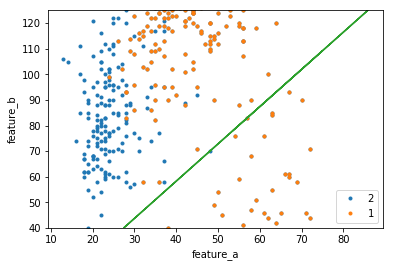

Training accuracy without bias at  2 th step: 
48.91640866873065
Testing accuracy without bias at  2 th step: 
50.0
Boundary without bias at  2 th step: 


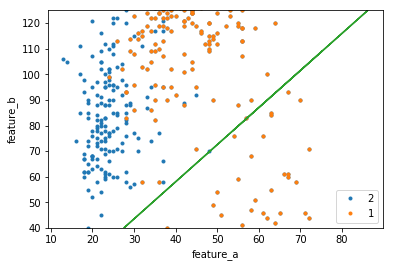

Training accuracy without bias at  3 th step: 
48.91640866873065
Testing accuracy without bias at  3 th step: 
50.0
Boundary without bias at  3 th step: 


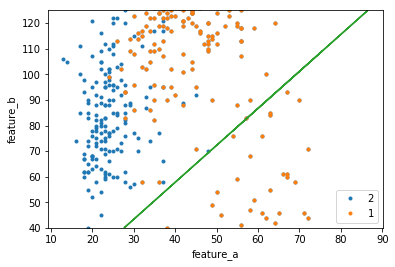

Training accuracy without bias at  4 th step: 
48.91640866873065
Testing accuracy without bias at  4 th step: 
50.0
Boundary without bias at  4 th step: 


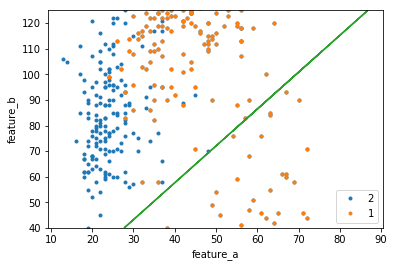

Training accuracy without bias at  5 th step: 
48.91640866873065
Testing accuracy without bias at  5 th step: 
50.0
Boundary without bias at  5 th step: 


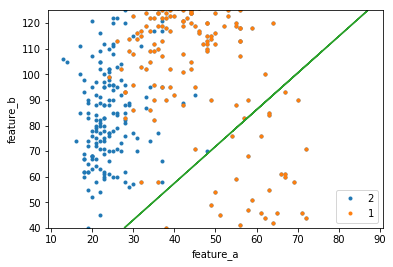

Training accuracy without bias at  6 th step: 
49.22600619195047
Testing accuracy without bias at  6 th step: 
50.0
Boundary without bias at  6 th step: 


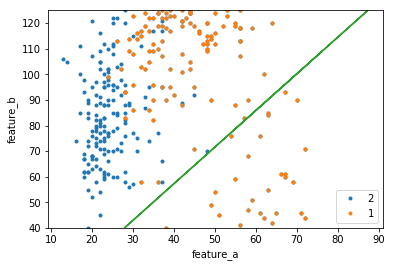

Training accuracy without bias at  7 th step: 
49.22600619195047
Testing accuracy without bias at  7 th step: 
50.0
Boundary without bias at  7 th step: 


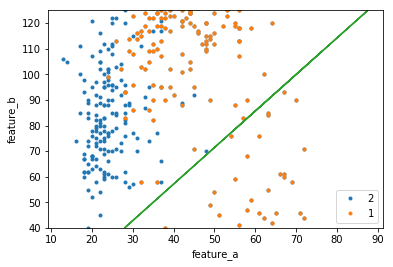

Training accuracy without bias at  8 th step: 
49.22600619195047
Testing accuracy without bias at  8 th step: 
50.0
Boundary without bias at  8 th step: 


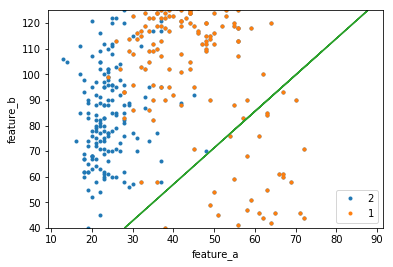

Training accuracy without bias at  9 th step: 
49.22600619195047
Testing accuracy without bias at  9 th step: 
50.0
Boundary without bias at  9 th step: 


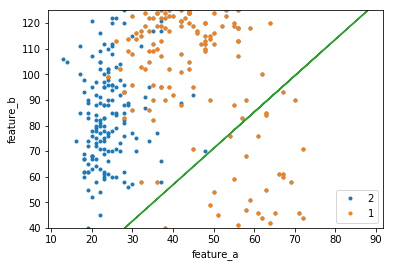

In [14]:
# Without bias
num_iterations = 10 # set this to the number of iterations
delta = 1e-2 # This may need to be adjusted
interval = num_iterations/10
step_size = 1e-2

w = -np.random.rand(2) # init weights to some random value.
grad = np.ones((2,))
for i in range(num_iterations):
    w1 = np.copy(w)
    w1[0] = w1[0]+delta
    w2 = np.copy(w)
    w2[1] = w2[1]+delta
    grad[0] = (logistic_loss(X_features, logistic_y, w1)-logistic_loss(X_features, logistic_y, w))/delta
    grad[1] = (logistic_loss(X_features, logistic_y, w2)-logistic_loss(X_features, logistic_y, w))/delta
#     grad = grad/norm(grad)
#     print(grad)
#     print(w)
    w -= step_size * (grad)
    if i % interval == 0:
        print('Training accuracy without bias at ', str(i), 'th step: ')
        print(accuracy_metrics(X_features, pseudo_y, w, t=0.5))

        print('Testing accuracy without bias at ', str(i), 'th step: ')
        print(accuracy_metrics(X_features_test, pseudo_y_test, w, t=0.5))
        
        print('Boundary without bias at ', str(i), 'th step: ')
        visualize_model(X_features, X_features_a, X_features_b, pseudo_y, w)

# Part II

Now let’s repeat the exercise above, but using a different set of features. Here, let’s assume that we have a camera that has just two pixels in it, which is taking pictures of the MNIST image dataset. One of these two pixels will detect the total intensity from the top half of each digit to form feature x_1, and the other pixel will detect the total intensity from the bottom half of each digit to form feature x_2. Please use these two top/bottom total intensities to form a new feature vector for each MNIST image that you’re using for classification, and repeat the exercise above to obtain a plot of classification performance and an average classification accuracy score. 

**Note that this classification score (in some sense) reflects what would be possible with a "normal" camera.**

 - Plot Points after feature generation
 - Linear Classification (Pseudo or Gradient method)
   - test/train accuracy
 - Logistic Classification
   - test/train accuracy

In [24]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        top = np.sum(image[0:3, :])

        return top

    def compute_feature_b(image):
        bottom = np.sum(image[4:7, :])

        return bottom
    
    return compute_feature_a(image), compute_feature_b(image)


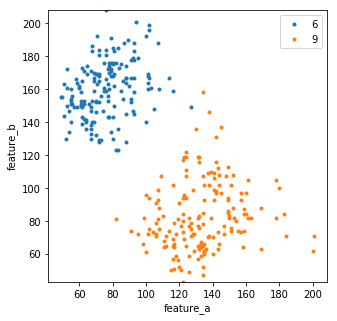

In [25]:
# Rechoose numbers and get the training/testing set
number_a = 6
number_b = 9

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)

# Compute features and plot
X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

X_features_test = np.apply_along_axis(compute_features, 1,
                                 X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.legend([str(number_a), str(number_b)])
plt.xlabel('feature_a')
plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 
plt.show()

Training accuracy: 
99.69135802469135
Testing accuracy: 
100.0


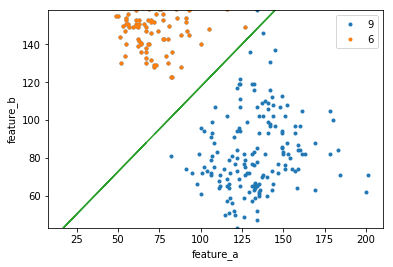

In [26]:
pseudo_y = np.copy(y_train)
pseudo_y[y_train == number_a] = -1
pseudo_y[y_train == number_b] = 1

pseudo_y_test = np.copy(y_test)
pseudo_y_test[y_test == number_a] = -1
pseudo_y_test[y_test == number_b] = 1

# Pseudo method
X_features_bias = np.c_[np.ones((X_features.shape[0], 1)), X_features]  # Concat a ones vector to X_features to account for bias
pseudoinv_X = np.matmul(inv(np.matmul(X_features_bias.T, X_features_bias)), X_features_bias.T)  # Recalculate pvin of X
w_b = np.matmul(pseudoinv_X, pseudo_y)

# Get the test and train accuracy of your model with bias
print('Training accuracy: ')
print(accuracy_metrics(X_features, pseudo_y, w_b))

print('Testing accuracy: ')
print(accuracy_metrics(X_features_test, pseudo_y_test, w_b))

# Visualize the model, you may need to change your code.
visualize_model(X_features, X_features_a, X_features_b, pseudo_y, w_b)

Training accuracy without bias at  0 th step: 
0.0
Testing accuracy without bias at  0 th step: 
0.0
Boundary without bias at  0 th step: 


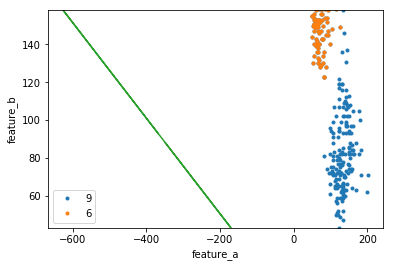

Training accuracy without bias at  1 th step: 
0.0
Testing accuracy without bias at  1 th step: 
0.0
Boundary without bias at  1 th step: 


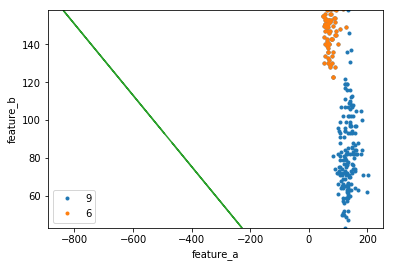

Training accuracy without bias at  2 th step: 
0.0
Testing accuracy without bias at  2 th step: 
0.0
Boundary without bias at  2 th step: 


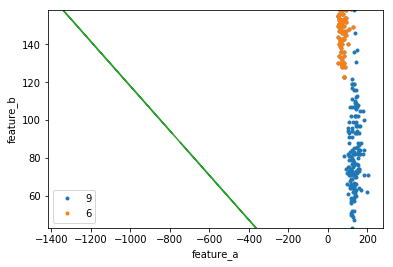

Training accuracy without bias at  3 th step: 
0.0
Testing accuracy without bias at  3 th step: 
0.0
Boundary without bias at  3 th step: 


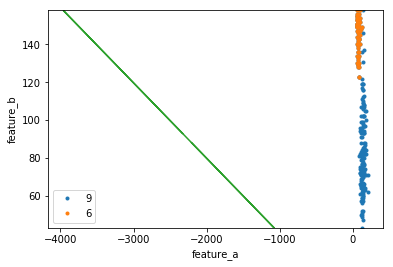

Training accuracy without bias at  4 th step: 
0.0
Testing accuracy without bias at  4 th step: 
0.0
Boundary without bias at  4 th step: 


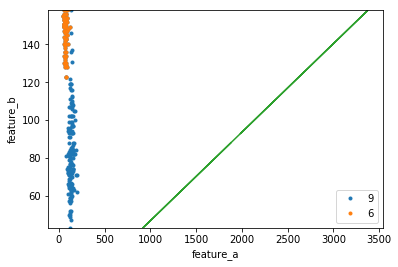

Training accuracy without bias at  5 th step: 
0.0
Testing accuracy without bias at  5 th step: 
0.0
Boundary without bias at  5 th step: 


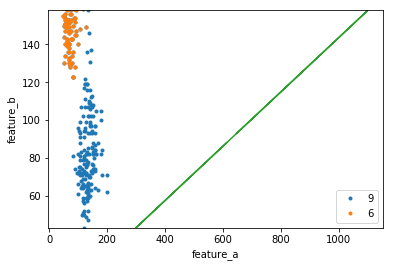

Training accuracy without bias at  6 th step: 
0.0
Testing accuracy without bias at  6 th step: 
0.0
Boundary without bias at  6 th step: 


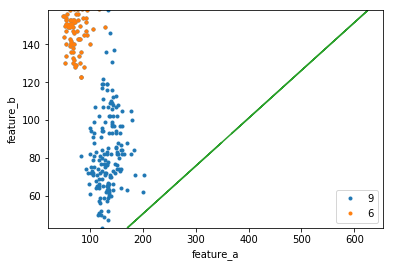

Training accuracy without bias at  7 th step: 
1.2345679012345678
Testing accuracy without bias at  7 th step: 
2.7027027027027026
Boundary without bias at  7 th step: 


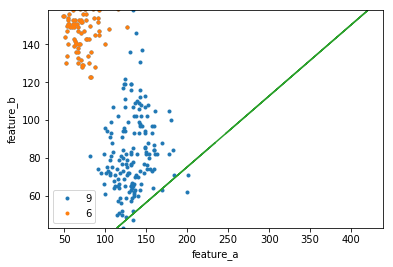

Training accuracy without bias at  8 th step: 
13.88888888888889
Testing accuracy without bias at  8 th step: 
8.108108108108109
Boundary without bias at  8 th step: 


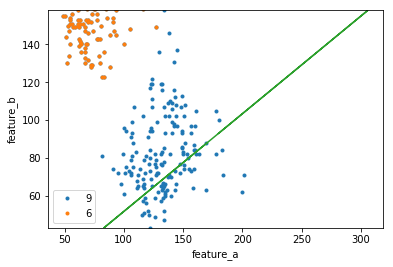

Training accuracy without bias at  9 th step: 
31.17283950617284
Testing accuracy without bias at  9 th step: 
27.027027027027028
Boundary without bias at  9 th step: 


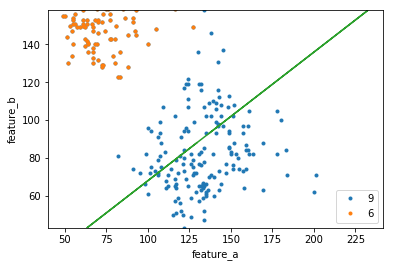

In [34]:
logistic_y = np.copy(y_train)
logistic_y[y_train == number_a] = 0
logistic_y[y_train == number_b] = 1

logistic_y_test = np.copy(y_test)
logistic_y_test[y_test == number_a] = 0
logistic_y_test[y_test == number_b] = 1

# Without bias
num_iterations = 10 # set this to the number of iterations
delta = 1e-2 # This may need to be adjusted
interval = num_iterations/10
step_size = 5e-2

w = -np.random.rand(2) # init weights to some random value.
grad = np.ones((2,))
for i in range(num_iterations):
    w1 = np.copy(w)
    w1[0] = w1[0]+delta
    w2 = np.copy(w)
    w2[1] = w2[1]+delta
    grad[0] = (logistic_loss(X_features, logistic_y, w1)-logistic_loss(X_features, logistic_y, w))/delta
    grad[1] = (logistic_loss(X_features, logistic_y, w2)-logistic_loss(X_features, logistic_y, w))/delta
    grad = grad/norm(grad)
#     print(w)
    w -= step_size * (grad)
    if i % interval == 0:
        print('Training accuracy without bias at ', str(i), 'th step: ')
        print(accuracy_metrics(X_features, pseudo_y, w, t=0.5))

        print('Testing accuracy without bias at ', str(i), 'th step: ')
        print(accuracy_metrics(X_features_test, pseudo_y_test, w, t=0.5))
        
        print('Boundary without bias at ', str(i), 'th step: ')
        visualize_model(X_features, X_features_a, X_features_b, pseudo_y, w)

# Part III

Finally, let’s assume that this camera has a special filter in its lens that blurs the MNIST image in a special way before it is detected. Let’s model this 2D blur as a convolution with the 3x3 filter below.

$$X = 
\begin{bmatrix}
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
    -1 & 0 & 1 \\
\end{bmatrix}$$

Convolve the set of MNIST images with this kernel before proceeding to compute the two features of interest as in Part I: the total image intensity, and the image symmetry. Repeat the exercise above to obtain a plot of classification performance and an average classification accuracy score.

**Note that this classification score (in some sense) reflects what would be possible with a “computational” camera, which has a special aperture shape for enhanced image classification.**

 - Plot Points after feature generation
 - Linear Classification (Pseudo or Gradient method)
   - test/train accuracy
 - Logistic Classification
   - test/train accuracy

In [19]:
from scipy import signal
from scipy.signal import convolve2d
# Init kernel
kernel = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

# Rechoose numbers and get the training/testing set
number_a = 1
number_b = 2

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)

for i in range(X_train.shape[0]):
    X_train[i,:,:] = convolve2d(X_train[i,:,:], kernel, mode='same')
    
for i in range(X_test.shape[0]):
    X_test[i,:,:] = convolve2d(X_test[i,:,:], kernel, mode='same')

In [20]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        feature1 = np.sum(np.sum(image*image.T))/10  # Calculate image symmetry (dividing by 10 gives better result)

        return feature1

    def compute_feature_b(image):
        feature2 = np.sum(np.sum(image))  # Calculate total intensity of the image

        return feature2
    
    return compute_feature_a(image), compute_feature_b(image)

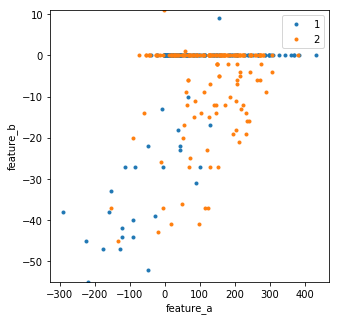

In [21]:
# Compute features and plot
X_features = np.apply_along_axis(compute_features, 1,
                                 X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))

X_features_a = X_features[np.where(y_train==number_a)]
X_features_b = X_features[np.where(y_train==number_b)]

X_features_test = np.apply_along_axis(compute_features, 1,
                                 X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

plt.figure(figsize=(5,5))
plt.plot(X_features_a[:, 0], X_features_a[:, 1], '.')
plt.plot(X_features_b[:, 0], X_features_b[:, 1], '.')
plt.legend([str(number_a), str(number_b)])
plt.xlabel('feature_a')
plt.ylabel('feature_b')
plt.ylim(X_features[:, 1].min(), X_features[:, 1].max()) 
plt.show()

Training accuracy: 
64.39628482972137
Testing accuracy: 
58.333333333333336


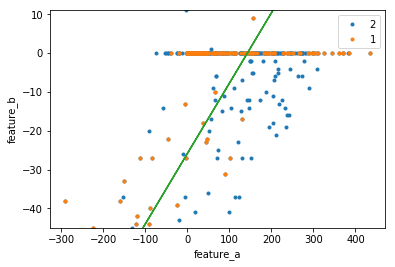

In [22]:
pseudo_y = np.copy(y_train)
pseudo_y[y_train == number_a] = -1
pseudo_y[y_train == number_b] = 1

pseudo_y_test = np.copy(y_test)
pseudo_y_test[y_test == number_a] = -1
pseudo_y_test[y_test == number_b] = 1

# Pseudo method
X_features_bias = np.c_[np.ones((X_features.shape[0], 1)), X_features]  # Concat a ones vector to X_features to account for bias
pseudoinv_X = np.matmul(inv(np.matmul(X_features_bias.T, X_features_bias)), X_features_bias.T)  # Recalculate pvin of X
w_b = np.matmul(pseudoinv_X, pseudo_y)

# Get the test and train accuracy of your model with bias
print('Training accuracy: ')
print(accuracy_metrics(X_features, pseudo_y, w_b))

print('Testing accuracy: ')
print(accuracy_metrics(X_features_test, pseudo_y_test, w_b))

# Visualize the model, you may need to change your code.
visualize_model(X_features, X_features_a, X_features_b, pseudo_y, w_b)

Training accuracy without bias at  0 th step: 
48.60681114551084
Testing accuracy without bias at  0 th step: 
47.22222222222222
Boundary without bias at  0 th step: 


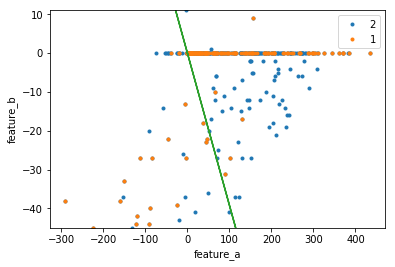

Training accuracy without bias at  1 th step: 
50.15479876160991
Testing accuracy without bias at  1 th step: 
47.22222222222222
Boundary without bias at  1 th step: 


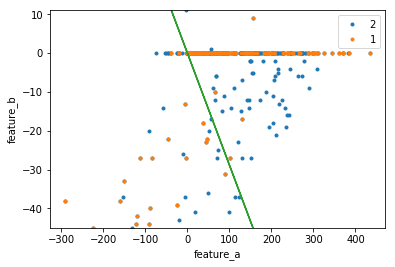

Training accuracy without bias at  2 th step: 
50.77399380804953
Testing accuracy without bias at  2 th step: 
47.22222222222222
Boundary without bias at  2 th step: 


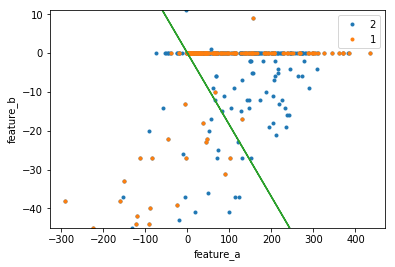

Training accuracy without bias at  3 th step: 
54.79876160990712
Testing accuracy without bias at  3 th step: 
52.77777777777778
Boundary without bias at  3 th step: 


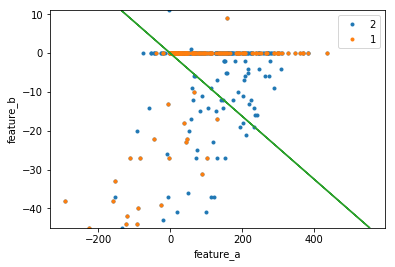

Training accuracy without bias at  4 th step: 
47.987616099071204
Testing accuracy without bias at  4 th step: 
52.77777777777778
Boundary without bias at  4 th step: 


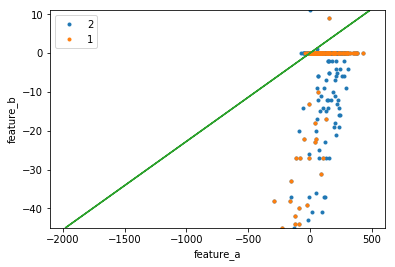

Training accuracy without bias at  5 th step: 
54.179566563467496
Testing accuracy without bias at  5 th step: 
52.77777777777778
Boundary without bias at  5 th step: 


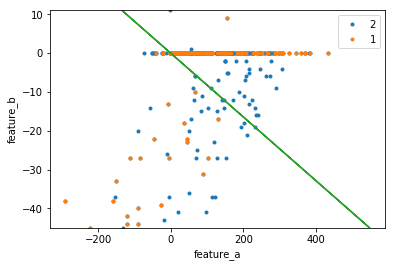

Training accuracy without bias at  6 th step: 
47.987616099071204
Testing accuracy without bias at  6 th step: 
52.77777777777778
Boundary without bias at  6 th step: 


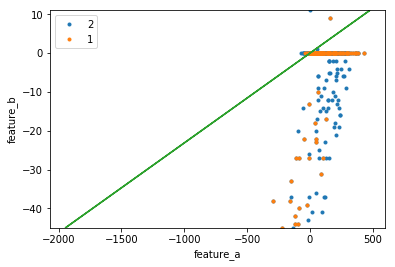

Training accuracy without bias at  7 th step: 
54.179566563467496
Testing accuracy without bias at  7 th step: 
52.77777777777778
Boundary without bias at  7 th step: 


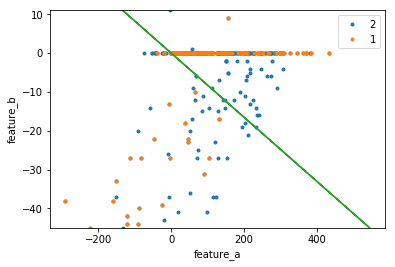

Training accuracy without bias at  8 th step: 
47.987616099071204
Testing accuracy without bias at  8 th step: 
52.77777777777778
Boundary without bias at  8 th step: 


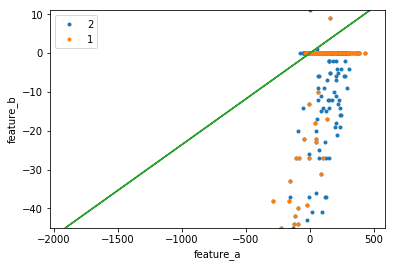

Training accuracy without bias at  9 th step: 
54.179566563467496
Testing accuracy without bias at  9 th step: 
52.77777777777778
Boundary without bias at  9 th step: 


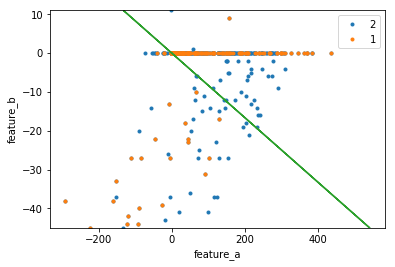

In [23]:
logistic_y = np.copy(y_train)
logistic_y[y_train == number_a] = -1
logistic_y[y_train == number_b] = 1

logistic_y_test = np.copy(y_test)
logistic_y_test[y_test == number_a] = -1
logistic_y_test[y_test == number_b] = 1

# Without bias
num_iterations = 10 
delta = 1e-2
interval = num_iterations/10
step_size = 1e-1

w = -np.random.rand(2) # init weights to some random value.
grad = np.ones((2,))
for i in range(num_iterations):
    w1 = np.copy(w)
    w1[0] = w1[0]+delta
    w2 = np.copy(w)
    w2[1] = w2[1]+delta
    grad[0] = (logistic_loss(X_features, logistic_y, w1)-logistic_loss(X_features, logistic_y, w))/delta
    grad[1] = (logistic_loss(X_features, logistic_y, w2)-logistic_loss(X_features, logistic_y, w))/delta
    grad = grad/norm(grad)
    w -= step_size * (grad)
    if i % interval == 0:
        print('Training accuracy without bias at ', str(i), 'th step: ')
        print(accuracy_metrics(X_features, pseudo_y, w))

        print('Testing accuracy without bias at ', str(i), 'th step: ')
        print(accuracy_metrics(X_features_test, pseudo_y_test, w))
        
        print('Boundary without bias at ', str(i), 'th step: ')
        visualize_model(X_features, X_features_a, X_features_b, pseudo_y, w)